In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import argparse
import torch
from tqdm import tqdm
import data_loader.data_loaders as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer import Trainer
from utils import Logger
import importlib
print("Modules loaded")

importlib.reload(module_data) #load recent changes to data_loaders.py
importlib.reload(module_arch)
print("Reload complete")

Modules loaded
Reload complete


In [43]:
#This function gets the parameters from the config.json file 
def get_instance(module, name, config, *args):
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])

def main(config, resume):
    train_logger = Logger() #uses entries to store training performance metrics

    # setup data_loader instances
    data_loader = get_instance(module_data, 'data_loader', config) #looks in data_loader/data_loaders.py for 'MNISTDataLoader'
    #print(os.path.isfile(data_loader.dataset))
    valid_data_loader = data_loader.split_validation() #allocate some images as validation

    # build model architecture
    model = get_instance(module_arch, 'arch', config) #looks in the model/model.py for 'MnistModel', as specified by config
    print(model)
    print(torch.cuda.get_device_name(0))

    # get function handles of loss and metrics
    loss = getattr(module_loss, config['loss']) #looks in model/loss.py for 'nll_loss'
    metrics = [getattr(module_metric, met) for met in config['metrics']] #get all the metrics in model/metrics.py - default is accuracy and top 3 accuracy

    # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
    trainable_params = filter(lambda p: p.requires_grad, model.parameters()) #Number of training params
    optimizer = get_instance(torch.optim, 'optimizer', config, trainable_params)
    lr_scheduler = get_instance(torch.optim.lr_scheduler, 'lr_scheduler', config, optimizer)

    trainer = Trainer(model, loss, metrics, optimizer,
                      resume=resume, #choose a previous epoch to start training from
                      config=config,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler,
                      train_logger=train_logger)

    trainer.train()



In [44]:
config_file = 'config_traffic.json'
# load config file
with open(config_file) as handle:
    config = json.load(handle)
# setting path to save trained models and log files
path = os.path.join(config['trainer']['save_dir'], config['name'])

In [45]:
#Train the network
main(config, None)

traffic2Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=43, bias=True)
)
Trainable parameters: 64811
Tesla K80


Train Epoch: 1 [0/35289 (0%)] Loss: 0.005587
Train Epoch: 1 [512/35289 (1%)] Loss: -0.068333
Train Epoch: 1 [1024/35289 (3%)] Loss: -0.923643
Train Epoch: 1 [1536/35289 (4%)] Loss: -9.577555
Train Epoch: 1 [2048/35289 (6%)] Loss: -54.264137
Train Epoch: 1 [2560/35289 (7%)] Loss: -291.362152
Train Epoch: 1 [3072/35289 (9%)] Loss: -959.259583
Train Epoch: 1 [3584/35289 (10%)] Loss: -2895.474854
Train Epoch: 1 [4096/35289 (12%)] Loss: -6759.349609
Train Epoch: 1 [4608/35289 (13%)] Loss: -16411.763672
Train Epoch: 1 [5120/35289 (14%)] Loss: -36833.132812
Train Epoch: 1 [5632/35289 (16%)] Loss: -77473.093750
Train Epoch: 1 [6144/35289 (17%)] Loss: -124302.906250
Train Epoch: 1 [6656/35289 (19%)] Loss: -235149.921875
Train Epoch: 1 [7168/35289 (20%)] Loss: -379480.468750
Train Epoch: 1 [7680/35289 (22%)] Loss: -588335.187500
Train Epoch: 1 [8192/35289 (23%)] Loss: -903285.125000
Train Epoch: 1 [8704/35289 (25%)] Loss: -1596334.250000
Train Epoch: 1 [9216/35289 (26%)] Loss: -2073393.500000
Tr

Train Epoch: 2 [32768/35289 (93%)] Loss: -222136320000.000000
Train Epoch: 2 [33280/35289 (94%)] Loss: -291285303296.000000
Train Epoch: 2 [33792/35289 (96%)] Loss: -289718239232.000000
Train Epoch: 2 [34304/35289 (97%)] Loss: -301540114432.000000
Train Epoch: 2 [34816/35289 (99%)] Loss: -320114491392.000000
    val_my_metric2 : 0.16784274193548387
    epoch          : 2
    val_my_metric  : 0.05871975806451613
    val_loss       : -320110008518.19354
    my_metric      : 0.05695199275362319
    my_metric2     : 0.16780570652173912
    loss           : -104969329974.72464
Saving checkpoint: saved/trafficSigns_withCSV/0521_160357/checkpoint-epoch2.pth ...
Saving current best: model_best.pth ...
Train Epoch: 3 [0/35289 (0%)] Loss: -359613923328.000000
Train Epoch: 3 [512/35289 (1%)] Loss: -336843997184.000000
Train Epoch: 3 [1024/35289 (3%)] Loss: -361903325184.000000
Train Epoch: 3 [1536/35289 (4%)] Loss: -374358278144.000000
Train Epoch: 3 [2048/35289 (6%)] Loss: -382817370112.000000
T

KeyboardInterrupt: 

In [118]:
def main2(config, resume):
    # setup data_loader instances
    data_loader = getattr(module_data, config['data_loader']['type'])(
        config['data_loader']['args']['data_dir'],
        batch_size=512,
        shuffle=False,
        validation_split=0.0,
        training=False,
        num_workers=2
    )
    
    # build model architecture
    model = get_instance(module_arch, 'arch', config)
    print(model)
    print(torch.cuda.get_device_name(0))


    
    # get function handles of loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]
    
    # load state dict
    checkpoint = torch.load(resume)
    state_dict = checkpoint['state_dict'] #dictionary of model parameters from saved file
    if config['n_gpu'] > 1:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(state_dict) 
    
    # prepare model for testing
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval() #tells model to ignore dropout and batch normalization
    
    total_loss = 0.0
    total_metrics = torch.zeros(len(metric_fns))
    
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad(): #speed up calculations, unable to perform back propogation
        for i, (data, target) in enumerate(tqdm(data_loader)): #tqdm is a progress bar
            data, target = data.to(device), target.to(device)
            output = model(data)
            #
            # save sample images, or do something with output here
            #
            
            
            if i < 5:
                fig = plt.figure()
                output_cpu = output.to(torch.device("cpu"))
                target_cpu = target.to(torch.device("cpu"))
                idx = (np.argmax(output_cpu[1], axis=0))
                cls = classes[idx]
                plt.title("Prediction = " + str(cls) + " | Actual = " + str(classes[target_cpu[1].numpy()]) )
                data_cpu = data.to(torch.device("cpu"))
                img = data_cpu[1]
                print(data_cpu.shape)
                plt.imshow(np.transpose(np.reshape(img,(3, 32,32)), (1,2,0))/2+0.5) #un-normalize and realign
                
            # computing loss, metrics on test set
            loss = loss_fn(output, target)
            batch_size = data.shape[0]
            total_loss += loss.item() * batch_size
            for i, metric in enumerate(metric_fns):
                total_metrics[i] += metric(output, target) * batch_size
        
        plt.show()
                      
    n_samples = len(data_loader.sampler)
    print("num samples = " + str(n_samples))
    log = {'loss': total_loss / n_samples}
    log.update({met.__name__: total_metrics[i].item() / n_samples for i, met in enumerate(metric_fns)})
    print(log)
    print("My_metric is accuracy, my_metric2 is top-3 accuracy")

In [119]:
resume = "saved/cifar_fromTAR/0520_203356/model_best.pth"

print(os.path.isdir("saved/cifar_fromTAR/0520_203356"))
print(os.path.exists(resume))

#config = torch.load("saved/Mnist_LeNet/0414_203632/config.json")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

True
True


  0%|          | 0/20 [00:00<?, ?it/s]

Cifar10Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Trainable parameters: 62006
Tesla K80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
  5%|▌         | 1/20 [00:00<00:05,  3.69it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 15%|█▌        | 3/20 [00:00<00:03,  4.68it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 25%|██▌       | 5/20 [00:00<00:02,  5.75it/s]

torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])


100%|██████████| 20/20 [00:01<00:00, 12.47it/s]


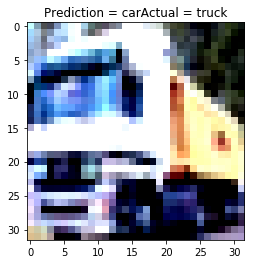

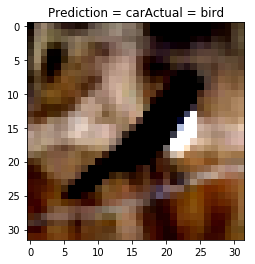

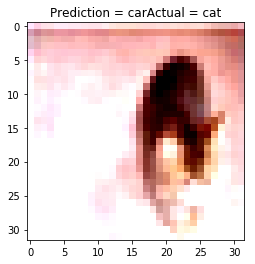

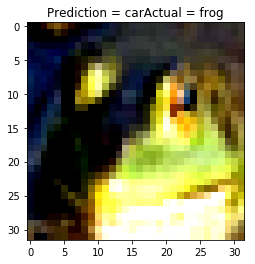

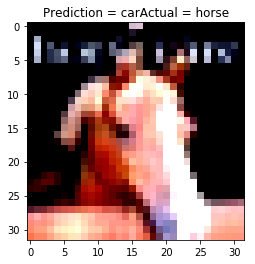

num samples = 10000
{'loss': -314659231546055.06, 'my_metric2': 0.3022, 'my_metric': 0.0974}
My_metric is accuracy, my_metric2 is top-3 accuracy


In [120]:
#Test
main2(config, resume)